# Critical Difference Plot on Surrogate Performance

Produces an image similar to:

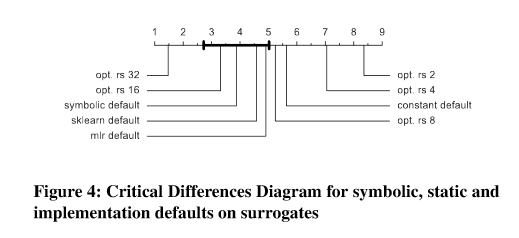

In [57]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

os.mkdir("generated/Figure4")
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'generated/Figure4'

In [58]:
surrogate_performance = pd.read_csv("surrogate_performance.csv", sep=';', header=0)
opt_random_search = pd.read_csv("optimistic_random_search.csv", sep=';', header=0)
all_methods = pd.concat([surrogate_performance, opt_random_search])

In [59]:
def category_from_row(row):
    if '_' in row['optimizer']:
        return row['optimizer'].replace('_', ' ')
    elif row['optimizer'] == "mupluslambda":
        if row['constants']:
            return "constant default"
        else:
            return "symbolic default"
    else:
        raise ValueError(f"Unknown category for {row}")

all_methods["category"] = all_methods.apply(category_from_row, axis=1)

In [60]:
import Orange

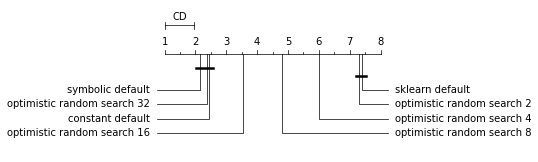

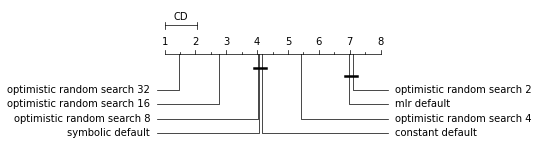

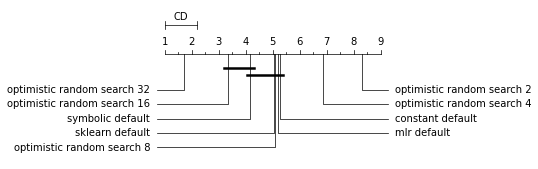

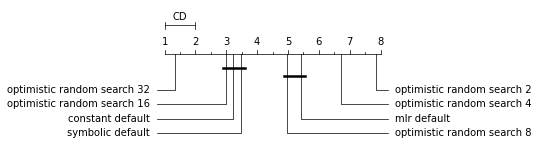

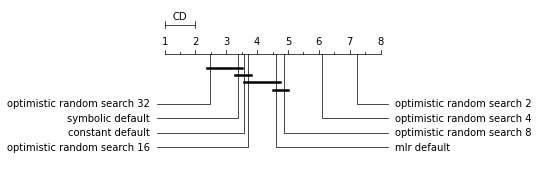

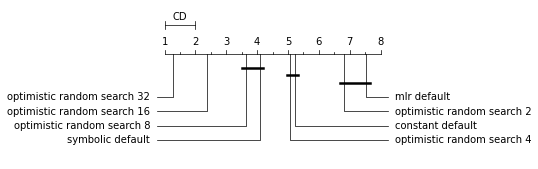

In [61]:
for learner in all_methods.learner.unique():
    learner_data = all_methods[all_methods.learner == learner].copy()
    learner_data["optimizer_rank"] = learner_data.groupby("task").surrogate_score.rank(ascending=False)
    n_tasks = learner_data.task.nunique()
    names = learner_data.optimizer.unique()
    average_rank_df = learner_data.groupby("category", as_index=False)["optimizer_rank"].mean()
    critical_difference = Orange.evaluation.compute_CD(average_rank_df["optimizer_rank"], n_tasks)
    Orange.evaluation.graph_ranks(
        average_rank_df["optimizer_rank"],
        average_rank_df["category"],
        # cdmethod = (average_rank_df["category"] == "symbolic default").argmax(),
        cd=critical_difference,
        width=6,
        textspace=1.5
    )
    plt.savefig(f"generated/Figure4/cd_surrogates_{learner}.pdf", bbox_inches='tight', pad_inches=.1)